In [2]:
import pandas as pd
import numpy as np
import networkx as nx
import random
import matplotlib.pyplot as plt

In [3]:
data = pd.read_csv('london_20002016_all_raw_8am.csv')

data

,cp,year,pc,2wmv,car,bus,lgv,hgv_total,min_month,min_dayofmonth,hour,min_idir,max_idir
0,6000,2000,0,51,2564,14,318,155,3,27,8,N,S
1,6000,2001,0,102,2654,15,355,243,5,10,8,N,S
2,6000,2002,0,119,2963,19,412,263,6,17,8,N,S
3,6000,2004,0,79,2890,13,360,225,4,30,8,N,S
4,6000,2005,0,112,2789,23,438,281,5,13,8,N,S
...,...,...,...,...,...,...,...,...,...,...,...,...,...
12758,999994,2004,2,0,127,1,7,1,6,18,8,N,S
12759,999994,2005,1,0,137,2,15,0,6,17,8,N,S
12760,999994,2006,0,0,151,0,29,0,6,23,8,N,S
12761,999994,2008,2,0,161,1,14,1,6,20,8,E,W


In [4]:
data_cleaned = data.drop(['pc', '2wmv', 'hour', 'min_idir', 'max_idir', 'hour', 'min_dayofmonth', 'min_month'], axis = 1)

data_cleaned['total_vehicles'] = data_cleaned[['car', 'bus', 'lgv', 'hgv_total']].sum(axis=1)

data_cleaned = data_cleaned.drop(['car', 'bus', 'lgv', 'hgv_total'], axis = 1)

data_cleaned['cp'].nunique()

2548

In [5]:
data_2016 = data_cleaned[data_cleaned['year'] == 2016]

data_2016

,cp,year,total_vehicles
7,6000,2016,3219
36,6013,2016,9298
52,6071,2016,5213
93,6096,2016,1896
106,6097,2016,7727
...,...,...,...
11331,951754,2016,331
11339,951759,2016,142
11348,951761,2016,104
11360,951767,2016,14


In [6]:
metadata = pd.read_csv('Metadata.csv')

metadata.head()

#filter metadata to keep only large roads (A roads and M roads)

filtered_metadata = metadata[metadata['properties/road'].str.contains('^(A|M)\d', na=False, regex=True)]

filtered_road_names = filtered_metadata['properties/road'].unique()

#now apply this to the data

filtered_data = data_2016[data_2016['cp'].notna() & data_2016['cp'].isin(filtered_metadata['properties/cp'])]

filtered_data

/var/folders/_n/ncvf_8sn4q712vl6jmdyfrvm0000gn/T/ipykernel_47760/548506789.py:7: UserWarning: This pattern is interpreted as a regular expression, and has match groups. To actually get the groups, use str.extract.
  filtered_metadata = metadata[metadata['properties/road'].str.contains('^(A|M)\d', na=False, regex=True)]


,cp,year,total_vehicles
7,6000,2016,3219
36,6013,2016,9298
52,6071,2016,5213
93,6096,2016,1896
106,6097,2016,7727
...,...,...,...
7626,86050,2016,165
7627,87003,2016,3437
7628,88038,2016,6150
7703,99902,2016,6063


<Axes: >

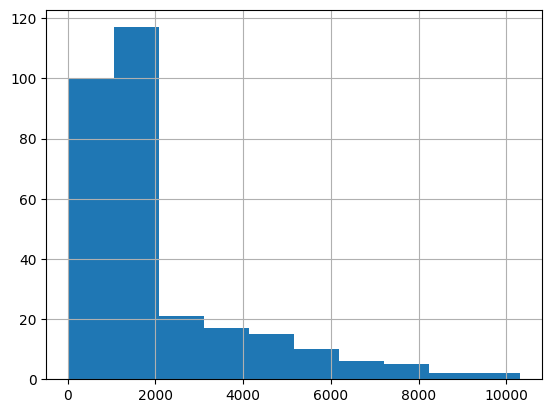

In [17]:
merged_data = pd.merge(data_2016, filtered_metadata[['properties/cp', 'properties/road']], left_on='cp', right_on='properties/cp', how='left')

filtered_data_with_road = merged_data[merged_data['properties/road'].notna()]

filtered_data_with_road['total_vehicles'].hist()


In [24]:
filtered_data_with_road_unique = filtered_data_with_road.drop_duplicates(subset=['properties/road'])

# Select only the 'total_vehicles' and 'road_name' columns
final_data = filtered_data_with_road_unique[['total_vehicles', 'properties/road']]


In [31]:


# Function to generate nodes and assign capacities
def generate_nodes_and_capacities(roads):
    nodes = []
    capacities = {}
    distances = {}

    for road in roads:
        prefix = road.split('_')[0]  # Assuming the road name might include an underscore
        if prefix.startswith("M"):
            capacity = random.randint(6000, 9000)
            distance = random.randint(500, 2000)
            num_nodes = 5
        elif prefix.startswith("A"):
            length = len(road) - 1  # Exclude the letter 'A'
            if length == 1:
                capacity = random.randint(3000, 6000)
                distance = random.randint(100, 1000)
                num_nodes = 4
            elif length == 2:
                capacity = random.randint(1000, 3000)
                distance = random.randint(100, 1000)
                num_nodes = 3
            elif length == 3:
                capacity = random.randint(500, 1000)
                distance = random.randint(100, 1000)
                num_nodes = 2
            else:
                capacity = random.randint(15, 500)
                distance = random.randint(100, 1000)
                num_nodes = 2

        for i in range(num_nodes):
            node_name = f"{road}_{chr(97 + i)}"
            nodes.append(node_name)
            capacities[node_name] = capacity
            distances[node_name] = distance

    return nodes, capacities, distances

roads = final_data['properties/road']
nodes, capacities, distances = generate_nodes_and_capacities(roads)

# Initialize used counts for each node
used_counts = {node: 0 for node in nodes}

# Randomly generate edges
random.seed(42)
edge_list = []

while any(count < 2 for count in used_counts.values()):
    node_a, node_b = random.sample(nodes, 2)
    if node_a != node_b and used_counts[node_a] < 4 and used_counts[node_b] < 4:
        # Determine capacity based on the node's road type
        road_a = node_a.split('_')[0]
        capacity = capacities[node_a]
        distance = distances[node_a]
        edge_list.append((node_a, node_b, capacity, distance))
        used_counts[node_a] += 1
        used_counts[node_b] += 1

print(edge_list)


[('A215_b', 'A12_c', 584, 949), ('A3211_a', 'A210_b', 340, 270), ('A20_b', 'A404_b', 1275, 302), ('A206_a', 'A315_b', 765, 293), ('A114_a', 'A503_b', 829, 828), ('A2_d', 'A2_c', 5726, 760), ('A117_b', 'A1055_a', 969, 493), ('A109_b', 'A2217_a', 757, 212), ('A2_a', 'A4180_b', 5726, 760), ('A41_b', 'A315_b', 1855, 637), ('A5204_b', 'A1055_b', 460, 815), ('A234_b', 'A200_a', 884, 934), ('M1_d', 'A504_b', 7480, 1792), ('A503_b', 'A239_a', 705, 842), ('A200_a', 'A501_b', 540, 400), ('A307_b', 'A24_b', 590, 483), ('A206_a', 'A117_b', 765, 293), ('A4006_a', 'A201_b', 470, 451), ('A316_b', 'A244_a', 992, 879), ('A4202_b', 'A5_b', 224, 551), ('A3002_b', 'A214_a', 366, 774), ('A232_b', 'A3220_b', 756, 645), ('A103_a', 'A4127_a', 506, 219), ('A1206_a', 'A502_b', 47, 450), ('A2215_b', 'A3217_a', 169, 952), ('A23_b', 'A5_c', 2184, 778), ('A100_a', 'A213_a', 749, 286), ('A103_a', 'A109_b', 506, 219), ('A205_b', 'A4006_a', 800, 182), ('A200_a', 'A2208_a', 540, 400), ('A1003_a', 'A598_b', 257, 875), (

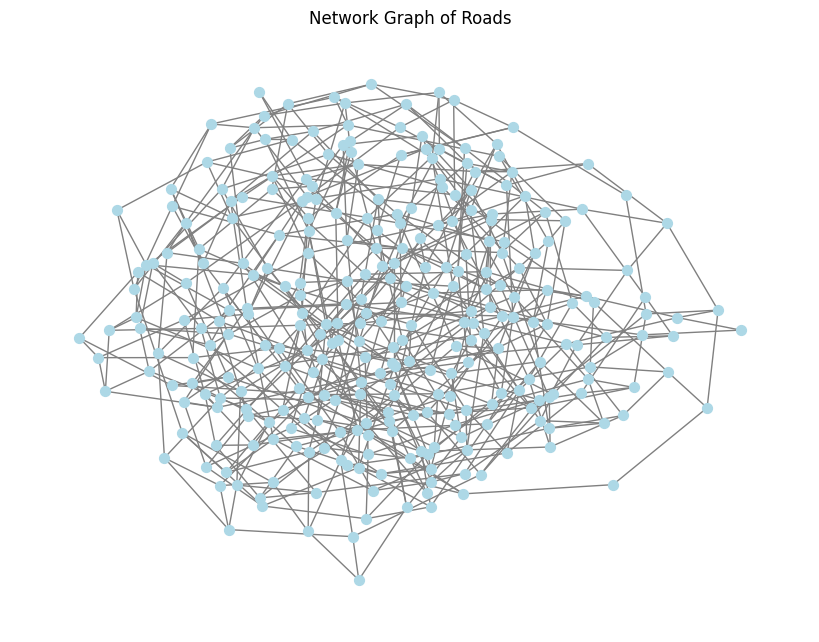

In [34]:
import networkx as nx
import matplotlib.pyplot as plt

# Assuming your edge_list includes capacities as the third element in each tuple
# Convert edge list with capacities to a format NetworkX can use for edge attributes
edge_list_with_attrs = [(node_a, node_b, {'capacity': capacity, 'distance': distance}) for node_a, node_b, capacity, distance in edge_list]

# Create a new graph
G = nx.Graph()
G.add_edges_from(edge_list_with_attrs)

# Now draw the graph
plt.figure(figsize=(8, 6))
# When labels are False, nodes are not labeled with their ids, making the graph cleaner
nx.draw(G, with_labels=False, node_color='lightblue', node_size=50, edge_color='gray')
plt.title("Network Graph of Roads")
plt.show()